In [97]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf

In [98]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()
spark

# Exploratory Data Analysis

In [104]:
!ls work/preprocessed/

part-00000-12eb2afc-eb67-4343-ae57-bcf3247f5ba5-c000.snappy.parquet  _SUCCESS


In [108]:
review_fp = "hdfs://namenode:9000/review_data/preprocessed"
df = spark.read.csv(review_fp, header=True, inferSchema=True)
df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)
 |-- sentiment: string (nullable = true)

Total reviews: 3425
+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Thật tuyệt với gà...|     5|          0| positive|
|Quán sạch , đẹp ,...|     5|          0| positive|
|Nhân_viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



In [109]:
parquet_output_path = "hdfs://namenode:9000/preprocessed_parquet"
df.write.parquet(parquet_output_path)

In [114]:
df_parquet = spark.read.parquet("hdfs://namenode:9000/preprocessed_parquet")
df_parquet.show()

+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Thật tuyệt với gà...|     5|          0| positive|
|Quán sạch , đẹp ,...|     5|          0| positive|
|Nhân_viên bự con ...|     5|          0| positive|
|Gà giòn_tan , nón...|     5|          0| positive|
|Gà giòn_rụm , thấ...|     5|          0| positive|
|Nhân_viên thân th...|     5|          0| positive|
|Phục_vụ nhanh , n...|     5|          0| positive|
|Gà rán thì ở đâu ...|     5|          0| positive|
|Mình là fan KFC ,...|     5|          0| positive|
|Nhân_viên phục_vụ...|     5|          0| positive|
|Gà giòn ngon dù đ...|     5|          0| positive|
|Mình có ghé đây ă...|     5|          0| positive|
|Ghé quán vào 1 bu...|     5|          0| positive|
|Nhân_viên thân_th...|     5|          0| positive|
|Ăn nhiều br

In [115]:
# Total Rows & Columns
print(f"Total rows: {df_parquet.count()}")
print(f"Total columns: {len(df_parquet.columns)}\n")

print('Overview of columns:')
df_parquet.describe().show()

print('Count by rating:')
df_parquet.groupBy('rating').count().orderBy('rating').show()

Total rows: 3425
Total columns: 4

Overview of columns:
+-------+--------------------+------------------+-----------------+---------+
|summary|              review|            rating|      place_index|sentiment|
+-------+--------------------+------------------+-----------------+---------+
|  count|                3425|              3425|             3425|     3425|
|   mean|                NULL| 4.258978102189781|8.811678832116788|     NULL|
| stddev|                NULL|1.4544572187638496|5.209891653545296|     NULL|
|    min|( không chỉ chi_n...|                 1|                0| negative|
|    max|               🥳 🙌|                 5|               17| positive|
+-------+--------------------+------------------+-----------------+---------+

Count by rating:
+------+-----+
|rating|count|
+------+-----+
|     1|  496|
|     2|   68|
|     3|  113|
|     4|  124|
|     5| 2624|
+------+-----+



# **Visualization**

## *Distribution of ratings*

Based on the chart, it’s clear that most users gave 5-star ratings (**2624 reviews**), showing that they were really satisfied with the service.\
The number of lower ratings like 1 (**496 reviews**), 2 (**68 reviews**), or 3 (**113 reviews**) stars is quite small in comparison, implying that only a few people had negative experiences.

The strong concentration in high ratings suggests that the overall user feedback is very positive.

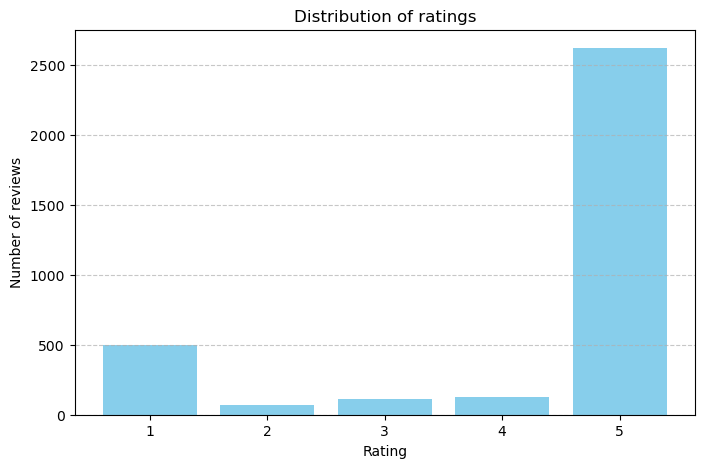

In [116]:
rating_distribution = df_parquet.groupBy('rating').count().orderBy('rating')

data = rating_distribution.collect()
ratings = [row['rating'] for row in data]
counts = [row['count'] for row in data]

plt.figure(figsize=(8, 5))
plt.title('Distribution of ratings')

plt.bar(ratings, counts, color='skyblue')

plt.xlabel('Rating')
plt.xticks(ratings)
plt.ylabel('Number of reviews')

plt.grid(axis='y', linestyle='--', alpha=0.7);

## `place_index` *by average rating*

From the chart, we can see that the average ratings across different places are generally high, most of them above 4.\
This shows that users tend to be quite satisfied overall. Place index 7 stands out with the highest average, close to 5 stars, while place 8 has the lowest, of below 4 stars.

The moderate variation between places suggests that service quality is fairly consistent, though some places clearly perform better than others.

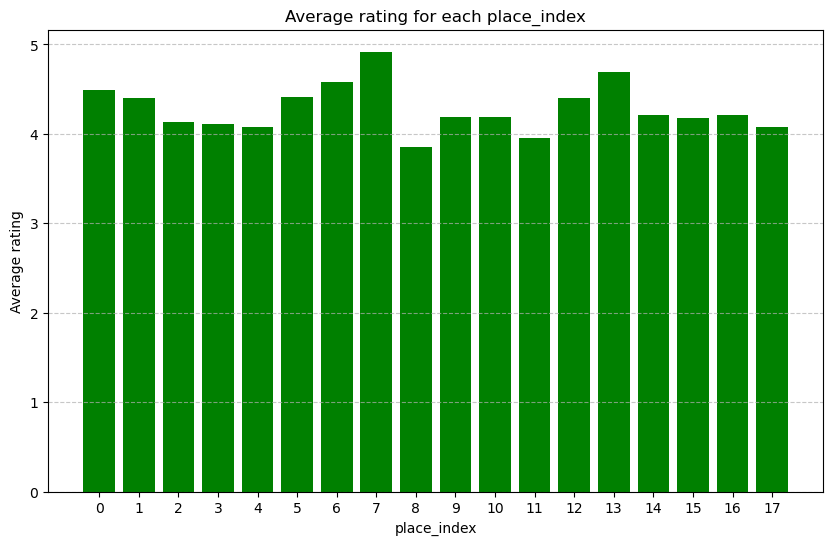

In [119]:
place_index_rating_avg = df_parquet.groupBy('place_index').avg('rating').orderBy('place_index')

data = place_index_rating_avg.collect()
place_indices = [row['place_index'] for row in data]
avg_ratings = [row['avg(rating)'] for row in data]

plt.figure(figsize=(10, 6))
plt.bar(place_indices, avg_ratings, color='green')
plt.xlabel('place_index')
plt.ylabel('Average rating')
plt.title('Average rating for each place_index')
plt.xticks(place_indices)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Word Count**

To better understand the common themes in the reviews, we analyzed the commonly used words within the reviews.

In [120]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, desc, length

The list of Vietnamese stopwords are provided by [`stopwords/vietnamese-stopwords`](https://github.com/stopwords/vietnamese-stopwords)

In [121]:
!wget -O vietnamese-stopwords-dash.txt https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt

--2025-04-29 07:50:18--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords-dash.txt’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0s      

2025-04-29 07:50:19 (41.2 MB/s) - ‘vietnamese-stopwords-dash.txt’ saved [20475/20475]



In [122]:
stopwords_path = "vietnamese-stopwords-dash.txt"
with open(stopwords_path, encoding='utf-8') as file:
    stopwords = {line.strip() for line in file}

In [123]:
def word_tokenize(row):
    return [(
        word, row['rating'],
        row['sentiment'], row['place_index']
        ) for word in row['review'].split()
    ]

tokenized_rdd = df_parquet.rdd.flatMap(word_tokenize)

In [154]:
# để đếm thì xài map như sau rồi reduce by key
count_global = tokenized_rdd.map(lambda row: (row[0], 1))
wc_global = count_global.reduceByKey(lambda x, y: x + y)

# By rating
count_by_rating = tokenized_rdd.map(lambda row: ((row[0], row[1]), 1))
wc_rating = count_by_rating.reduceByKey(lambda x, y: x + y)

# By sentiment & place_index
count_by_sent_place = tokenized_rdd.map(lambda row: ((row[0], row[2], row[3]), 1))
wc_sent_place = count_by_sent_place.reduceByKey(lambda x, y: x + y)

# By sentiment 
count_by_sent = tokenized_rdd.map(lambda row: ((row[0], row[2]), 1))
wc_sent = count_by_sent.reduceByKey(lambda x, y: x + y)

In [133]:
# Convert to Dict
wc_global.collectAsMap()

{'3': 115,
 'miếng': 112,
 'gà': 681,
 '105k': 1,
 'như': 227,
 'này': 253,
 'khác': 151,
 'gì': 143,
 '2': 203,
 'rưỡi': 1,
 'đâu': 48,
 'chứ': 57,
 'Gà': 254,
 'ướp': 12,
 'vừa': 68,
 'vị': 85,
 ',': 3910,
 'mọng': 22,
 'nước': 78,
 '.': 2363,
 'Dù': 6,
 'đông': 113,
 'nhưng': 347,
 'nhân_viên': 1082,
 'vẫn': 183,
 'rất': 713,
 'vui_vẻ': 140,
 'nhiệt_tình': 657,
 'đồ': 498,
 'ăn': 1489,
 'đc': 48,
 'phục_vụ': 456,
 'nhanh': 300,
 'Thật': 15,
 'tuyệt': 30,
 'với': 271,
 'ngon': 1199,
 'dịch_vụ': 92,
 'chu_đáo': 79,
 'và': 757,
 'nhất_định': 5,
 'sẽ': 196,
 'đến': 236,
 'nhiều': 195,
 'lần': 307,
 'sau': 116,
 'Quán': 122,
 'sạch': 51,
 'đẹp': 95,
 'thoáng': 127,
 'mát': 128,
 'tận_tình': 55,
 'mấy': 85,
 'chị': 46,
 'quản_lý': 91,
 'khách': 371,
 'Nhân_viên': 500,
 'bự': 3,
 'con': 53,
 'tên': 27,
 'Nam': 1,
 'sáng': 20,
 'ngày': 50,
 '12': 7,
 '/': 101,
 '03': 3,
 'hỗ_trợ': 51,
 'mình': 693,
 'oder': 29,
 'nch': 4,
 'nhẹ_nhàng': 4,
 'mong': 19,
 'quán': 243,
 'tiếp': 30,
 'tinh_thần'

In [ ]:
wc_sent_place.collectAsMap()

{('3', 'negative', 0): 3,
 ('miếng', 'negative', 0): 3,
 ('gà', 'negative', 0): 18,
 ('105k', 'negative', 0): 1,
 ('như', 'negative', 0): 2,
 ('này', 'negative', 0): 3,
 ('khác', 'negative', 0): 3,
 ('gì', 'negative', 0): 1,
 ('2', 'negative', 0): 6,
 ('rưỡi', 'negative', 0): 1,
 ('đâu', 'negative', 0): 1,
 ('chứ', 'negative', 0): 1,
 ('Gà', 'positive', 0): 24,
 ('ướp', 'positive', 0): 3,
 ('vừa', 'positive', 0): 2,
 ('vị', 'positive', 0): 7,
 (',', 'positive', 0): 160,
 ('mọng', 'positive', 0): 4,
 ('nước', 'positive', 0): 4,
 ('.', 'positive', 0): 65,
 ('Dù', 'positive', 0): 1,
 ('đông', 'positive', 0): 4,
 ('nhưng', 'positive', 0): 8,
 ('nhân_viên', 'positive', 0): 40,
 ('vẫn', 'positive', 0): 5,
 ('rất', 'positive', 0): 31,
 ('vui_vẻ', 'positive', 0): 10,
 ('nhiệt_tình', 'positive', 0): 46,
 ('đồ', 'positive', 0): 15,
 ('ăn', 'positive', 0): 50,
 ('đc', 'positive', 0): 1,
 ('phục_vụ', 'positive', 0): 20,
 ('nhanh', 'positive', 0): 14,
 ('Thật', 'positive', 0): 1,
 ('tuyệt', 'positi

In [135]:
wc_rating.collectAsMap()

{('3', 1): 71,
 ('miếng', 1): 65,
 ('gà', 1): 259,
 ('105k', 1): 1,
 ('như', 1): 111,
 ('này', 1): 110,
 ('khác', 1): 75,
 ('gì', 1): 83,
 ('2', 1): 141,
 ('rưỡi', 1): 1,
 ('đâu', 1): 30,
 ('chứ', 1): 35,
 ('Gà', 5): 192,
 ('ướp', 5): 6,
 ('vừa', 5): 24,
 ('vị', 5): 49,
 (',', 5): 2464,
 ('mọng', 5): 22,
 ('nước', 5): 31,
 ('.', 5): 952,
 ('Dù', 5): 1,
 ('đông', 5): 58,
 ('nhưng', 5): 114,
 ('nhân_viên', 5): 745,
 ('vẫn', 5): 68,
 ('rất', 5): 442,
 ('vui_vẻ', 5): 126,
 ('nhiệt_tình', 5): 638,
 ('đồ', 5): 334,
 ('ăn', 5): 985,
 ('đc', 5): 9,
 ('phục_vụ', 5): 369,
 ('nhanh', 5): 255,
 ('Thật', 5): 6,
 ('tuyệt', 5): 29,
 ('với', 5): 119,
 ('gà', 5): 292,
 ('ngon', 5): 1097,
 ('dịch_vụ', 5): 51,
 ('chu_đáo', 5): 76,
 ('và', 5): 347,
 ('nhất_định', 5): 4,
 ('sẽ', 5): 137,
 ('đến', 5): 99,
 ('nhiều', 5): 106,
 ('lần', 5): 126,
 ('sau', 5): 41,
 ('Quán', 5): 74,
 ('sạch', 5): 46,
 ('đẹp', 5): 84,
 ('thoáng', 5): 124,
 ('mát', 5): 121,
 ('tận_tình', 5): 54,
 ('mấy', 5): 40,
 ('chị', 5): 15,
 (

In [156]:
wc_sent.collectAsMap()

{('3', 'negative'): 83,
 ('miếng', 'negative'): 72,
 ('gà', 'negative'): 310,
 ('105k', 'negative'): 1,
 ('như', 'negative'): 127,
 ('này', 'negative'): 132,
 ('khác', 'negative'): 83,
 ('gì', 'negative'): 94,
 ('2', 'negative'): 158,
 ('rưỡi', 'negative'): 1,
 ('đâu', 'negative'): 35,
 ('chứ', 'negative'): 39,
 ('Gà', 'positive'): 212,
 ('ướp', 'positive'): 9,
 ('vừa', 'positive'): 27,
 ('vị', 'positive'): 59,
 (',', 'positive'): 2625,
 ('mọng', 'positive'): 22,
 ('nước', 'positive'): 38,
 ('.', 'positive'): 1127,
 ('Dù', 'positive'): 1,
 ('đông', 'positive'): 66,
 ('nhưng', 'positive'): 143,
 ('nhân_viên', 'positive'): 769,
 ('vẫn', 'positive'): 90,
 ('rất', 'positive'): 473,
 ('vui_vẻ', 'positive'): 128,
 ('nhiệt_tình', 'positive'): 642,
 ('đồ', 'positive'): 344,
 ('ăn', 'positive'): 1034,
 ('đc', 'positive'): 10,
 ('phục_vụ', 'positive'): 379,
 ('nhanh', 'positive'): 268,
 ('Thật', 'positive'): 6,
 ('tuyệt', 'positive'): 29,
 ('với', 'positive'): 130,
 ('gà', 'positive'): 330,
 ('n

In [182]:
import re
from string import punctuation

stopwords.update(set(punctuation))

def is_valid_key(key):
    # single string (wc_global)
    if isinstance(key, str):
        return (key not in stopwords and 
                not re.fullmatch(r'^\W+$', key) and #remove punctuation
                not re.fullmatch(r'^\d+$', key) #remove numbers
                )
    
    # tuple (wc_rating, wc_sent_place,...)
    elif isinstance(key, tuple):
        word = key[0]
        return (word not in stopwords and 
                not re.fullmatch(r'^\W+$', word) and #remove punctuation
                not re.fullmatch(r'^\d+$', word) #remove numbers
        )
    return True

filtered_global = {key: count for key, count in wc_global.collect() if is_valid_key(key)}
filtered_rating = {key: count for key, count in wc_rating.collect() if is_valid_key(key)}
filtered_sent_place = {key: count for key, count in wc_sent_place.collect() if is_valid_key(key)}
filtered_sent = {key: count for key, count in wc_sent.collect() if is_valid_key(key)}

The word frequency table shows that users often mention aspects related to service quality and food. Words like 'nhânviên', 'phụcvụ', 'nhiệttình', 'thânthiện', and 'dễthương' appear frequently, indicating a generally positive impression of customer service. In terms of food, words such as 'ngon', 'gà', 'giòn', 'món', and 'chiên' suggest that many users were satisfied with the food quality, especially chicken – a key product of KFC. Some negative or neutral words like 'tệ', 'đợi', 'ko', and 'k' also appear, but with lower frequency, implying that negative experiences exist but are not dominant.

In [146]:
from pyspark.sql import Row

global_df = spark.createDataFrame([Row(word=k, count=v) for k, v in filtered_global.items()])

print('Top 50 frequency keywords:')
global_df.orderBy('count', ascending=False).show(50, truncate=False)


Top 50 frequency keywords:
+----------+-----+
|word      |count|
+----------+-----+
|ngon      |1199 |
|nhân_viên |1082 |
|gà        |681  |
|nhiệt_tình|657  |
|Nhân_viên |500  |
|đồ        |498  |
|phục_vụ   |456  |
|thân_thiện|366  |
|dễ_thương |360  |
|món       |343  |
|Đồ        |335  |
|KFC       |277  |
|sạch_sẽ   |260  |
|Gà        |254  |
|ko        |248  |
|quán      |243  |
|giòn      |231  |
|đi        |216  |
|nóng      |171  |
|thái_độ   |171  |
|tệ        |170  |
|Mình      |167  |
|không_gian|165  |
|mua       |163  |
|đợi       |161  |
|nghiệm    |151  |
|ghé       |146  |
|k         |146  |
|vui_vẻ    |140  |
|nha       |137  |
|lắm       |134  |
|đơn       |131  |
|mát       |128  |
|thoáng    |127  |
|hơi       |126  |
|order     |126  |
|nv        |125  |
|khách_hàng|123  |
|Không_gian|123  |
|Quán      |122  |
|rán       |116  |
|giao      |115  |
|đông      |113  |
|chi_nhánh |113  |
|miếng     |112  |
|Ngon      |106  |
|combo     |105  |
|gọi       |101  |
|trả

# WordCloud

Wordcloud is a visualization tool that displays the frequency of words in a text dataset. This section uses the Python library wordcloud to create a Wordcloud image from customer's reviews 

In [35]:
!pip install wordcloud

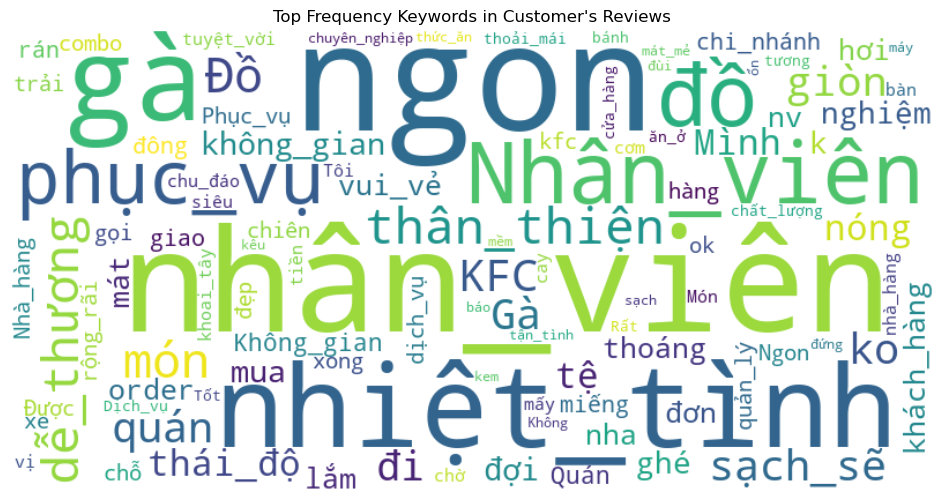

In [148]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

top_freqwords = sorted(filtered_global.items(), key=lambda x: x[1], reverse=True)[:100]
wordcloud_dict = dict(top_freqwords)

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     colormap='viridis').generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top Frequency Keywords in Customer's Reviews")
plt.show()

# Word Count by Sentiment

The word count for each sentiment (negative, postitive, neural) is examined to identify the most frequent terms associated with that sentiment. The table below displays the top words appearing most often in negative sentiment expressions, along with their respective frequency counts

In [161]:
from pyspark.sql import Row

# Create dataframe
sent_df = spark.createDataFrame(
    [Row(word=k[0], sentiment=k[1], count=v) 
     for k, v in filtered_sent.items()]
)

print('Top 50 frequency keywords by sentiment:')
sent_df.orderBy('count', ascending=False).show(50, truncate=False)

Top 50 frequency keywords by sentiment:
+----------+---------+-----+
|word      |sentiment|count|
+----------+---------+-----+
|ngon      |positive |1150 |
|nhân_viên |positive |769  |
|nhiệt_tình|positive |642  |
|Nhân_viên |positive |413  |
|phục_vụ   |positive |379  |
|thân_thiện|positive |356  |
|dễ_thương |positive |351  |
|đồ        |positive |344  |
|gà        |positive |330  |
|gà        |negative |310  |
|Đồ        |positive |309  |
|nhân_viên |negative |291  |
|sạch_sẽ   |positive |254  |
|Gà        |positive |212  |
|món       |positive |201  |
|giòn      |positive |185  |
|ko        |negative |185  |
|KFC       |positive |161  |
|tệ        |negative |154  |
|không_gian|positive |151  |
|nóng      |positive |138  |
|quán      |positive |136  |
|thái_độ   |negative |135  |
|đồ        |negative |131  |
|đợi       |negative |130  |
|vui_vẻ    |positive |128  |
|món       |negative |128  |
|thoáng    |positive |127  |
|mát       |positive |124  |
|đi        |negative |119  |
|k 

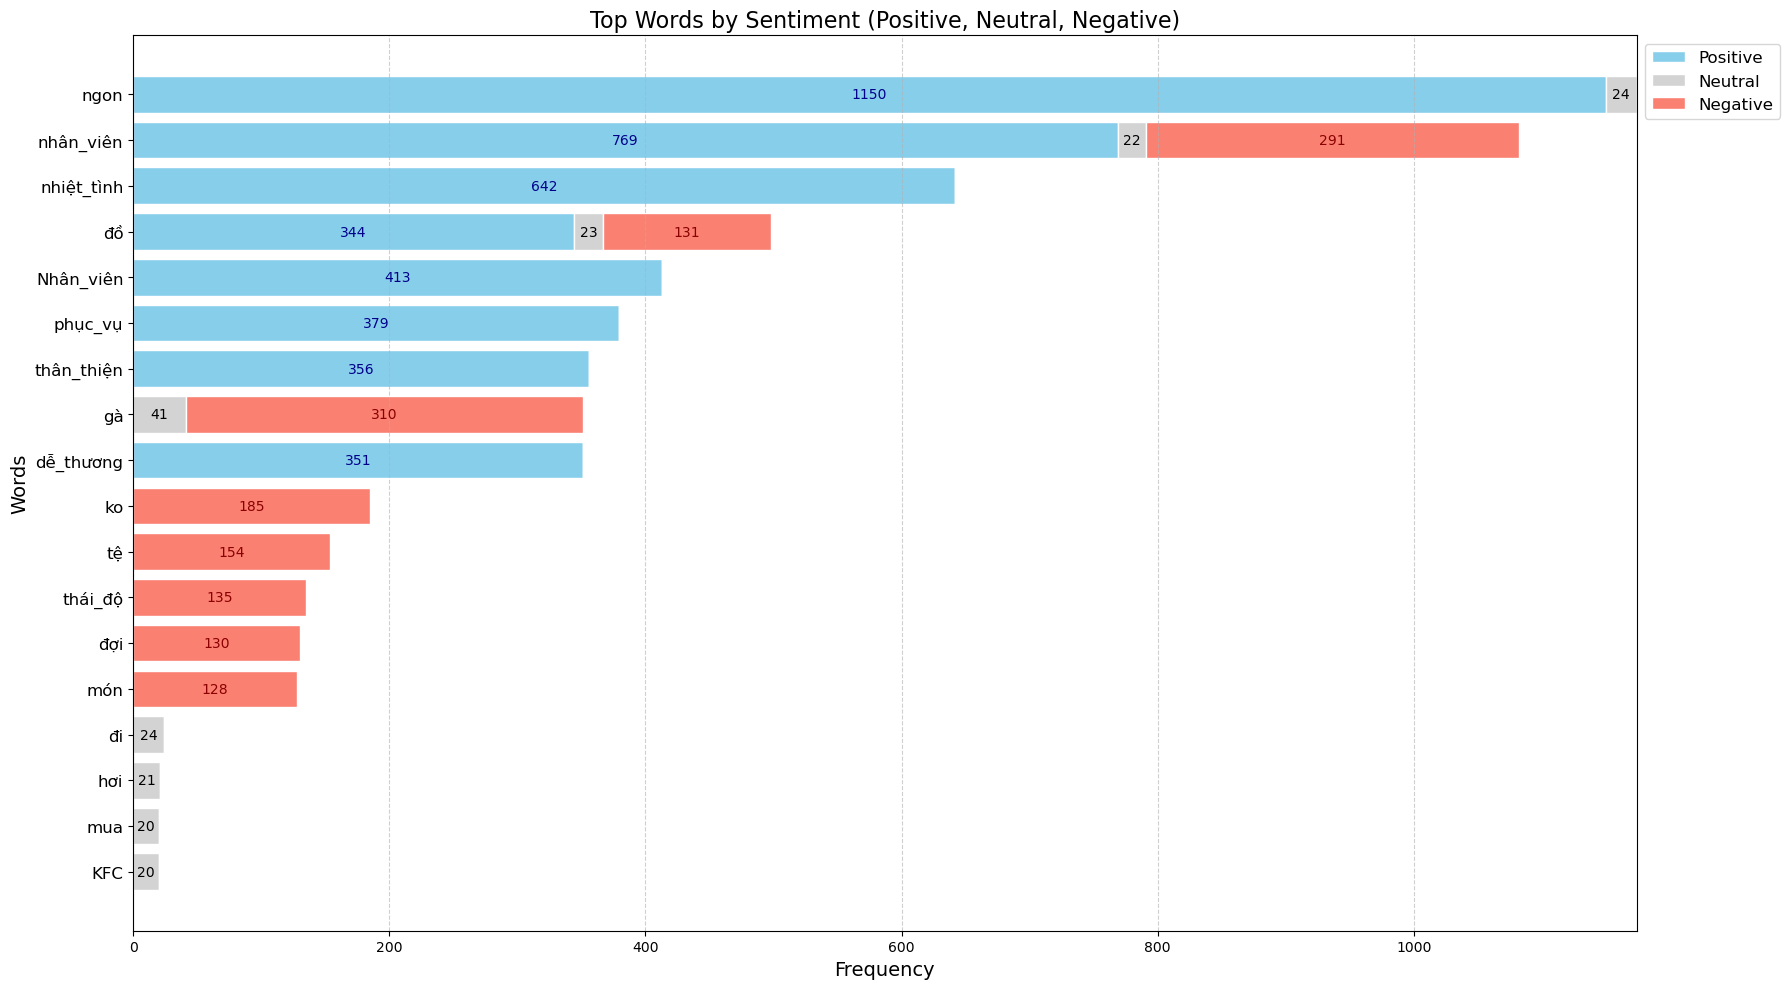

In [169]:
from pyspark.sql import functions as F

top_words = {}
sentiments = ['positive', 'neutral', 'negative']

for sentiment in sentiments:
    top_words[sentiment] = (
        sent_df.filter(F.col('sentiment') == sentiment)
        .orderBy(F.col('count').desc())
        .limit(8)
        .select('word', 'count')
        .rdd.collectAsMap()
    )

all_words = list(set(
    list(top_words['positive'].keys()) + 
    list(top_words['neutral'].keys()) + 
    list(top_words['negative'].keys())
))

df_plot = pd.DataFrame({
    'Word': all_words,
    'Positive': [top_words['positive'].get(word, 0) for word in all_words],
    'Neutral': [top_words['neutral'].get(word, 0) for word in all_words],
    'Negative': [top_words['negative'].get(word, 0) for word in all_words]
})

df_plot['Total'] = df_plot['Positive'] + df_plot['Neutral'] + df_plot['Negative']
df_plot = df_plot.sort_values('Total', ascending=True)

# Visualize stacked bar
plt.figure(figsize=(18, 10))

p1 = plt.barh(df_plot['Word'], df_plot['Positive'], 
              color='skyblue', label='Positive', edgecolor='white')
p2 = plt.barh(df_plot['Word'], df_plot['Neutral'], 
              left=df_plot['Positive'],
              color='lightgray', label='Neutral', edgecolor='white')
p3 = plt.barh(df_plot['Word'], df_plot['Negative'], 
              left=df_plot['Positive'] + df_plot['Neutral'],
              color='salmon', label='Negative', edgecolor='white')

for i, word in enumerate(df_plot['Word']):
    # Positive
    if df_plot['Positive'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i]/2, i,
                str(df_plot['Positive'].iloc[i]), 
                va='center', ha='center', color='darkblue', fontsize=10)
    
    # Neutral
    if df_plot['Neutral'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i]/2, i,
                str(df_plot['Neutral'].iloc[i]), 
                va='center', ha='center', color='black', fontsize=10)
    
    # Negative
    total_width = df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]
    if df_plot['Negative'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]/2, i,
                str(df_plot['Negative'].iloc[i]), 
                va='center', ha='center', color='darkred', fontsize=10)

plt.yticks(range(len(df_plot['Word'])), df_plot['Word'], fontsize=12)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top Words by Sentiment (Positive, Neutral, Negative)', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Word Count by Rating

In [172]:
rating_df = spark.createDataFrame(
    [Row(word=k[0], rating=k[1], count=v) 
     for k, v in filtered_rating.items()]
)

print('Top 50 frequency keywords by rating:')
rating_df.orderBy('count', ascending=False).show(50, truncate=False)

Top 50 frequency keywords by rating:
+----------+------+-----+
|word      |rating|count|
+----------+------+-----+
|ngon      |5     |1097 |
|nhân_viên |5     |745  |
|nhiệt_tình|5     |638  |
|Nhân_viên |5     |403  |
|phục_vụ   |5     |369  |
|thân_thiện|5     |349  |
|dễ_thương |5     |347  |
|đồ        |5     |334  |
|Đồ        |5     |302  |
|gà        |5     |292  |
|nhân_viên |1     |260  |
|gà        |1     |259  |
|sạch_sẽ   |5     |247  |
|Gà        |5     |192  |
|món       |5     |179  |
|giòn      |5     |175  |
|ko        |1     |174  |
|không_gian|5     |142  |
|tệ        |1     |139  |
|KFC       |5     |135  |
|nóng      |5     |133  |
|vui_vẻ    |5     |126  |
|thoáng    |5     |124  |
|quán      |5     |124  |
|mát       |5     |121  |
|đợi       |1     |116  |
|thái_độ   |1     |114  |
|món       |1     |113  |
|đồ        |1     |113  |
|nha       |5     |112  |
|đơn       |1     |109  |
|Ngon      |5     |106  |
|k         |1     |105  |
|Không_gian|5     |103  |
|

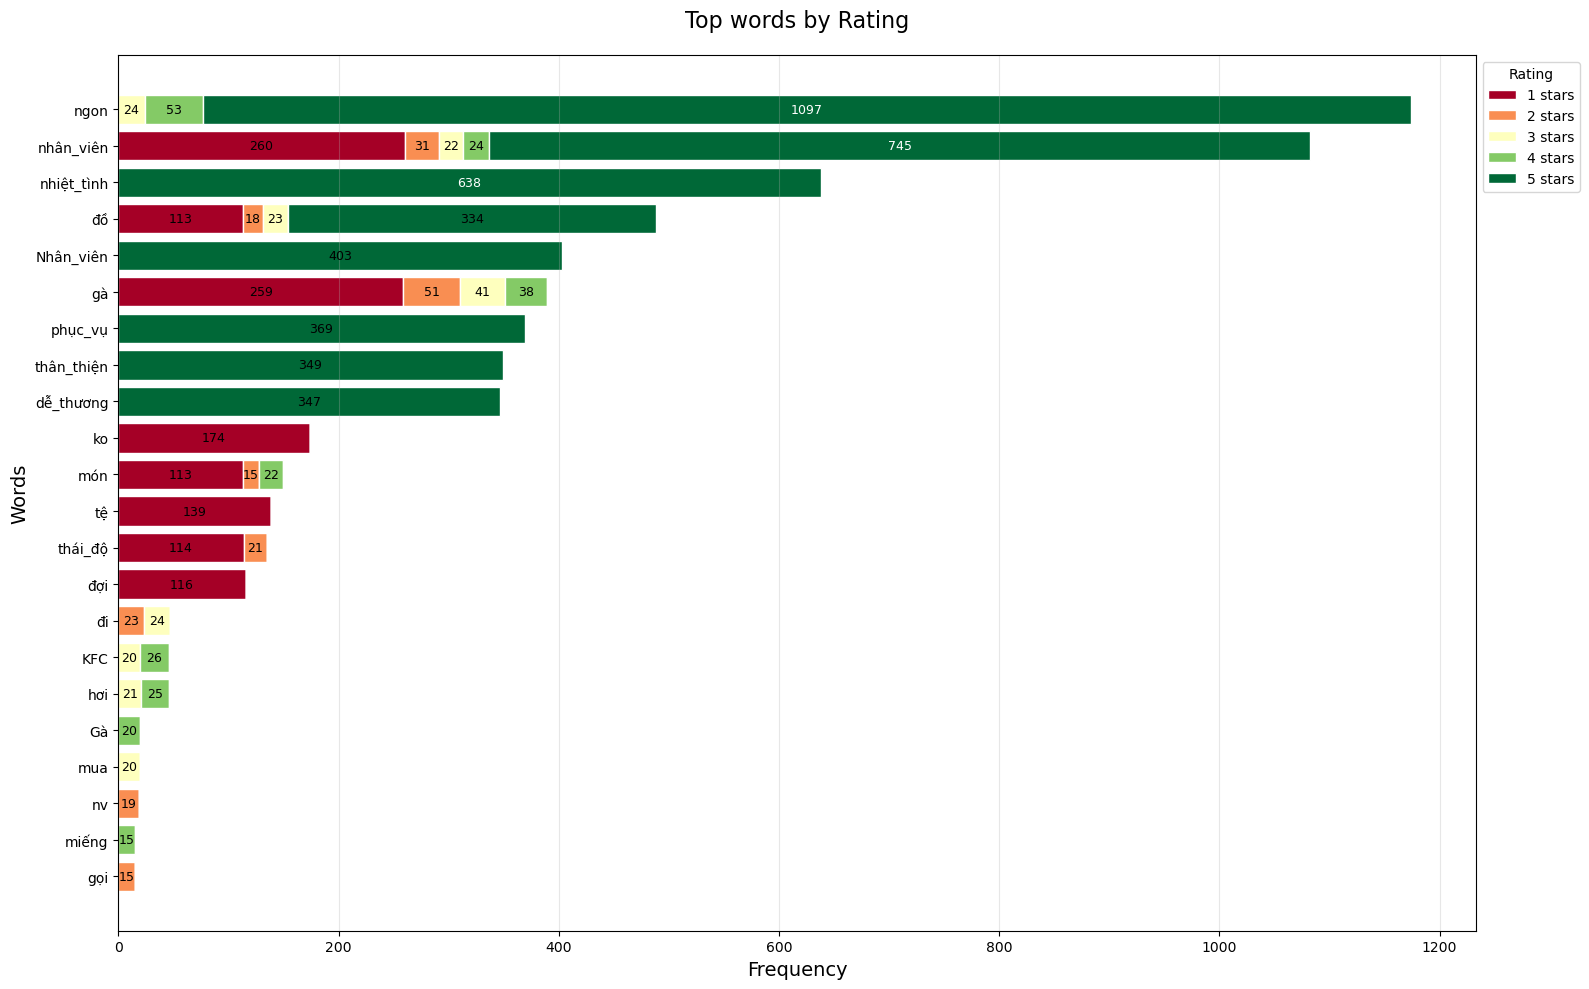

In [181]:
top_words = {}
ratings = [1,2,3,4,5]

for rating in ratings:
    top_words[rating] = (
        rating_df.filter(F.col('rating') == rating)
        .orderBy(F.col('count').desc())
        .limit(8)
        .select('word', 'count')
        .rdd.collectAsMap()
    )

all_words = list(set(
    list(top_words[1].keys()) + 
    list(top_words[2].keys()) + 
    list(top_words[3].keys()) + 
    list(top_words[4].keys()) + 
    list(top_words[5].keys())
))

df_plot = pd.DataFrame({'word': all_words})
for rating in [1, 2, 3, 4, 5]:
    df_plot[f'rating_{rating}'] = [top_words[rating].get(word, 0) for word in all_words]


df_plot['total'] = df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].sum(axis=1)
df_plot = df_plot.sort_values('total', ascending=True)

# Visualize stacked chart
plt.figure(figsize=(16, 10))
colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))

left = None
for idx, rating in enumerate([1, 2, 3, 4, 5]):
    plt.barh(
        df_plot['word'],
        df_plot[f'rating_{rating}'],
        color=colors[idx],
        label=f'{rating} stars',
        left=left,
        edgecolor='white'
    )
    left = df_plot[f'rating_{rating}'] if left is None else left + df_plot[f'rating_{rating}']

for i, word in enumerate(df_plot['word']):
    width = 0
    for rating in [1, 2, 3, 4, 5]:
        value = df_plot[f'rating_{rating}'].iloc[i]
        if value > 0:
            plt.text(
                width + value/2, i,
                str(int(value)), 
                va='center', ha='center',
                color='white' if value > max(df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].max())/2 else 'black',
                fontsize=9
            )
            width += value

plt.title('Top words by Rating', fontsize=16, pad=20)
plt.ylabel('Words', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.legend(title='Rating', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()